In [20]:
import numpy as np
import pandas as pd
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline






import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [24]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [25]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
    """
      bg_idx : list of indexes of background_data[] to be used as background images in mosaic
      fg_idx : index of image to be used as foreground image from foreground data
      fg : at what position/index foreground image has to be stored out of 0-8
    """
    image_list=[]
    j=0
    for i in range(9):
        if i != fg:
            image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
            j+=1
        else: 
            image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
            label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
    #image_list = np.concatenate(image_list ,axis=0)
    image_list = torch.stack(image_list) 
    return image_list,label

In [26]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)

In [27]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
        """
          Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.mosaic = mosaic_list_of_images
        self.label = mosaic_label
        self.fore_idx = fore_idx
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [31]:
class Module1(nn.Module):
    def __init__(self):
        super(Module1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = self.pool(x1)
        x = self.pool(F.relu(self.conv2(x1)))
        #print(x.shape)
        x = x.view(-1, 16 * 12* 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        #print("sdfdsa",x.shape,x1.shape)
        return x,x1

In [32]:
class Module2(nn.Module):
    def __init__(self):
        super(Module2, self).__init__()
        self.module1 = Module1().double()
        self.module1 = self.module1.to(device)
        self.conv1 = nn.Conv2d(6, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4* 4,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)
        
        
    def forward(self,z):  #z batch of list of 9 images
        y = torch.zeros([batch,6, 28,28], dtype=torch.float64)
        x = torch.zeros([batch,9],dtype=torch.float64)
        x1 = torch.zeros([batch,9,6,28,28],dtype=torch.float64)
        y  = y.to(device)
        x1,x = x1.to(device),x.to(device)
        #print(x1.shape,x.shape)
       
        #z = z.type(torch.DoubleTensor)
        
        #print(z.shape,z.dtype)
        
        for i in range(9):
            k,l  =  self.module1.forward(z[:,i,:,:,:])
            x[:,i] = k[:,0]
            x1[:,i,:,:,:] = l
            #print(k.shape)
        #print("123",x.shape,x1.shape)

        x = F.softmax(x,dim=1)
        #print(x.shape)

        #x2 = x[:,0]
        
#         print((x[0,0]*x1[0])[None,:,:,:].shape,y.shape)
        
        for i in range(9):
            x2 = x[:,i]          
            y = y + torch.mul(x2[:,None,None,None],x1[:,i])
            

        y1 = self.pool(F.relu(self.conv1(y)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        #print(y1.shape)
        y1 = y1.view(-1, 16 * 4* 4)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)

        return y1 , x, y

In [33]:
fore_net = Module2().double()
fore_net = fore_net.to(device)

In [34]:

test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [35]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [10]:
df_train = pd.read_csv("train_results.csv")
df_test = pd.read_csv("test_results.csv")

In [16]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,30000,2256,7772,3863,16109
1,9,0,30000,2218,7856,3917,16009
2,14,0,30000,2295,7783,3845,16077
3,19,0,30000,2547,7589,3632,16232
4,24,0,30000,1783,8464,4551,15202
5,29,0,30000,2520,8470,4021,14989
6,34,0,30000,3244,9177,4526,13053
7,39,0,30000,4143,9496,4854,11507
8,44,4165,25835,7768,8363,3999,9870
9,49,17103,12897,13729,6059,3007,7205


In [13]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

col1 = df_train[columns[0]]
col2 = df_train[columns[1]] 
col3 = df_train[columns[2]] 
col4 = df_train[columns[3]] 
col5 = df_train[columns[4]] 
col6 = df_train[columns[5]] 
col7 = df_train[columns[6]] 

col1 = df_test[columns[0]] 
col8 = df_test[columns[1]] 
col9 = df_test[columns[2]] 
col10 = df_test[columns[3]] 
col11 = df_test[columns[4]] 
col12 = df_test[columns[5]] 
col13 = df_test[columns[6]] 

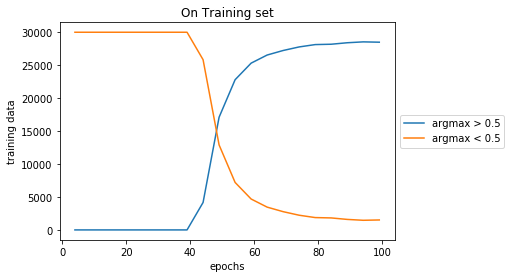

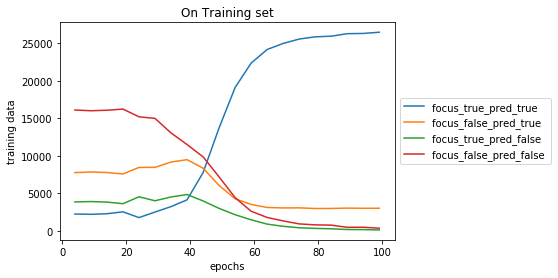

In [14]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [15]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,10000,360,2975,1650,5015
1,9,0,10000,927,2397,1097,5579
2,14,0,10000,915,2409,1111,5565
3,19,0,10000,908,2416,1150,5526
4,24,0,10000,909,2415,1231,5445
5,29,0,10000,950,2922,1281,4847
6,34,0,10000,1251,2939,1436,4374
7,39,0,10000,1439,3245,1485,3831
8,44,1415,8585,2813,2633,1396,3158
9,49,6456,3544,4722,1816,983,2479


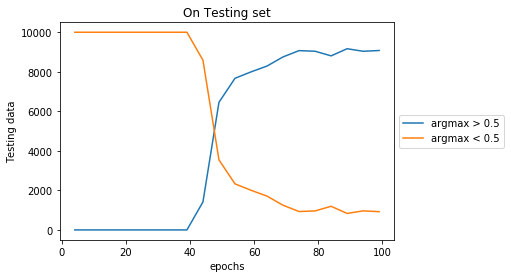

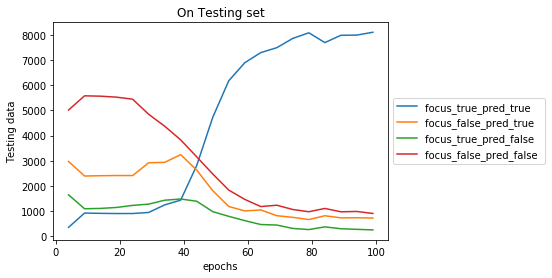

In [17]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()


In [18]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13)

-------------------- Training Dataset --------------------
epochs 0      4
1      9
2     14
3     19
4     24
5     29
6     34
7     39
8     44
9     49
10    54
11    59
12    64
13    69
14    74
15    79
16    84
17    89
18    94
19    99
Name: epochs, dtype: int64
argmax > 0.5  0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8      4165
9     17103
10    22796
11    25311
12    26542
13    27231
14    27772
15    28127
16    28181
17    28406
18    28539
19    28489
Name: argmax > 0.5, dtype: int64
argmax < 0.5  0     30000
1     30000
2     30000
3     30000
4     30000
5     30000
6     30000
7     30000
8     25835
9     12897
10     7204
11     4689
12     3458
13     2769
14     2228
15     1873
16     1819
17     1594
18     1461
19     1511
Name: argmax < 0.5, dtype: int64
focus_true_pred_true 0      2256
1      2218
2      2295
3      2547
4      1783
5      2520
6      3244
7      4143
8      7768
9     13729
10    19103


In [ ]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])


     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [ ]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)